In [2]:
# import usual packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [18]:
path='/content/drive/MyDrive/new data'
os.chdir(path)

In [19]:
os.listdir(path)

['aug_puffy_tomato',
 'aug_tomato_sunscald',
 'aug_dehiscent_fruit',
 'aug_tomato_anthracnose',
 'aug_tomato_malformed_fruit',
 'aug_buckeye_rot',
 'aug_tomato_blotchey_rippen',
 'aug_blossom_end_rot_tomato',
 'aug_bacterial_virus_spot_tomato',
 'aug_healthy_tomato']

In [20]:
d=[]
for j in os.listdir(path):
  d.append(len(os.listdir(path+'/'+j)))


In [21]:
sum(d)

3071

In [22]:
d

[276, 336, 330, 291, 315, 306, 332, 288, 296, 301]

In [23]:
os.listdir(path+'/aug_bacterial_virus_spot_tomato')[5]

'aug_0_6530680.png'

In [26]:
# sample image
buckrot = path+'/aug_bacterial_virus_spot_tomato'+'/aug_0_10628.png'

In [27]:
buckrot_img= imread(buckrot,'.png')

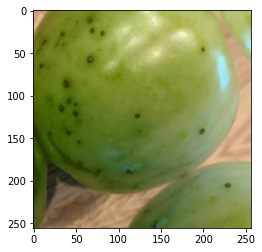

In [28]:
plt.imshow(buckrot_img)

In [29]:
buckrot_img.shape

(256, 256, 3)

In [30]:
path

'/content/drive/MyDrive/new data'

In [ ]:
# finding average image size / dimensions
dim1 = []
dim2 = []
k=0
import cv2
for j in os.listdir(path):
    new_path=path+'/'+j
    for i, filename in enumerate(os.listdir(new_path)):
        img=cv2.imread(new_path + "/" + filename)
        d1,d2,color = img.shape
        dim1.append(d1)
        dim2.append(d2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


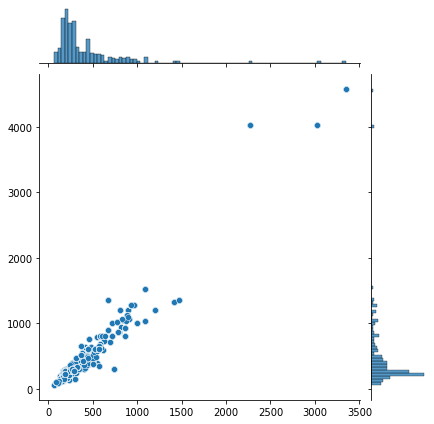

In [ ]:
sns.jointplot(dim1,dim2)
# vast majority of the images have resolution of 500x500

In [ ]:
print(np.mean(dim1))
print(np.mean(dim2))

411.18700209643606
477.6498951781971


In [ ]:
#image_shape = (400,450,3)
# reducing image size to hopefully get better training time
image_shape = (400,400,3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
# using ImageDataGenerator for batching and supplying images for training
# a few random rotations, height and width shift to vary the images to improve recognition
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               #rescale=1/255, # Rescale the image by normalzing it.
                               # note: not using rescale because we're using preprocessing function
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               validation_split=0.1, # adding validation split
                               preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
                               # note that inception_v3 requires the above preprocessing function to be used
                               # to set values between -1 & +1
                              )

In [ ]:
image_gen.flow_from_directory(path)


Found 8598 images belonging to 10 classes.


In [ ]:
# this is a ready keras application
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(
    weights='imagenet', include_top=False, 
    input_shape=image_shape, #pooling='avg'
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# ensuring we don't train the base model
base_model.trainable = False

In [ ]:
#x = base_model.output 
inputs = tf.keras.Input(shape=image_shape)
x = base_model(inputs, training=False)
# passing Inception output via pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # preventing overfitting with dropout
# Flattening the inputs to custom layers
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x) # try changing this
x = Dense(64, activation='relu')(x)
# and a logistic layer 
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=inputs, outputs=predictions)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',#rmsprop
              metrics=[tf.keras.metrics.Precision()]) #accuracy originally

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 11, 11, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6560

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)


In [ ]:
batch_size = 32

In [ ]:
# training images
train_image_gen = image_gen.flow_from_directory(path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical', 
                                                subset='training'
                                               )

Found 7743 images belonging to 10 classes.


In [ ]:
train_image_gen.class_indices

{'0Healthy tomato': 0,
 '1bacterial virus spot tomato': 1,
 '2blossom end rot tomato': 2,
 '3Tomato blotchy ripening': 3,
 '4buckeye rot': 4,
 '5Tomato malformed fruit': 5,
 '6Tomato anthracnose': 6,
 '7Tomato dehiscent fruit': 7,
 '8Toamto sunscald': 8,
 '9puffy tomato': 9}

In [ ]:
test_image_gen.class_indices

{'0Healthy tomato': 0,
 '1bacterial virus spot tomato': 1,
 '2blossom end rot tomato': 2,
 '3Tomato blotchy ripening': 3,
 '4buckeye rot': 4,
 '5Tomato malformed fruit': 5,
 '6Tomato anthracnose': 6,
 '7Tomato dehiscent fruit': 7,
 '8Toamto sunscald': 8,
 '9puffy tomato': 9}

In [ ]:
# validation images
test_image_gen = image_gen.flow_from_directory(path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset='validation')

Found 855 images belonging to 10 classes.


In [ ]:
pwd

'/content/drive/My Drive/final'

In [ ]:
model.fit(
    x=train_image_gen,
    epochs=200,
    callbacks=[early_stop],
    validation_data=test_image_gen
)

Epoch 1/200
 86/242 [=========>....................] - ETA: 35:23 - loss: 1.8791 - precision: 0.7311

KeyboardInterrupt: ignored

In [ ]:
# we'll need this for fine tuning later
# ensuring that fine tuning is only run for last training epochs - 1 (to prevent overtraining)
num_epochs = len(model.history.history) - 1

In [ ]:
losses = pd.DataFrame(model.history.history)
losses

,loss,precision_1,val_loss,val_precision_1
0,0.467234,0.912587,0.611368,0.777778
1,0.287556,0.936027,0.348616,0.960000
2,0.162634,0.964744,0.282773,0.928571
3,0.141459,0.977564,0.396101,0.884615
4,0.094022,0.977419,0.460822,0.866667
5,0.074635,0.990385,0.242699,0.896552
6,0.037695,0.993691,0.332638,0.866667
7,0.074098,0.977636,0.488691,0.821429
8,0.072752,0.977707,0.493585,0.866667
9,0.044003,0.987342,0.257144,0.900000


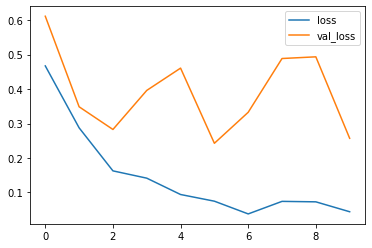

In [ ]:
losses[['loss','val_loss']].plot()

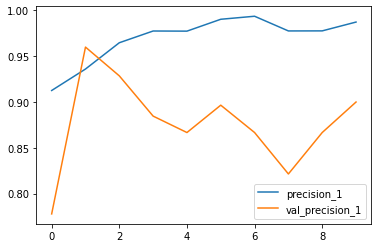

In [ ]:
losses[['precision_1','val_precision_1']].plot()

In [ ]:
model.evaluate(test_image_gen) 

2/2 [==============================] - 1s 526ms/step - loss: 1.0827 - precision: 0.7222


[1.0826873779296875, 0.7222222089767456]

In [ ]:
# setting base model as trainable
base_model.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-5),# Very low learning rate
              metrics=[tf.keras.metrics.Precision()]) #accuracy originally

In [ ]:
# using ImageDataGenerator for batching and supplying images for training
# a few random rotations, height and width shift to vary the images to improve recognition
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               #rescale=1/255, # Rescale the image by normalzing it.
                               # note: not using rescale because we're using preprocessing function
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               #validation_split=0.1, # adding validation split
                               preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
                               # note that inception_v3 requires the above preprocessing function to be used
                               # to set values between -1 & +1
                              )

In [ ]:
batch_size = 16
# training images
train_image_gen = image_gen.flow_from_directory(path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical'
                                               )

Found 347 images belonging to 8 classes.


In [ ]:
x=train_image_gen,
    epochs=200,
    callbacks=[early_stop],
    validation_data=test_image_gen

In [ ]:
# note: no callbacks or validation data as training on all available images
model.fit(
    x=train_image_gen,
    epochs=1,
    validation_data=test_image_gen
)

20/20 [==============================] - 18s 868ms/step - loss: 0.0450 - precision_1: 0.9905 - val_loss: 0.1493 - val_precision_1: 0.9655


In [ ]:
import tensorflow as tf

In [ ]:
path='/content/drive/MyDrive/tomato diseases cropped'
os.chdir(path)

In [ ]:
tf.keras.models.save_model('mod.h5')

TypeError: ignored

In [ ]:
model.save('my_model.h5')